Calculation of VHI and UHI. All of the tif files are merged into one as vector file for doing further analysis

In [1]:
# pip install contextily

In [2]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import rasterio
# import contextily as ctx
import os
import warnings
warnings.filterwarnings('ignore')
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pathlib

Defining the Function

In [3]:
def create_combined_geodataframe(ndvi_path, ndbi_path, lst_path, step_size=10):
    """
    Create a combined GeoDataFrame from NDVI, NDBI, and LST raster files.
    
    Parameters:
    -----------
    ndvi_path : str
        Path to the NDVI raster file
    ndbi_path : str
        Path to the NDBI raster file
    lst_path : str
        Path to the LST raster file
    step_size : int
        Sampling interval for points (default=10)
    
    Returns:
    --------
    GeoDataFrame with NDVI, NDBI, LST values and point geometries
    """
    # Initialize lists to store data
    points = []
    ndvi_values = []
    ndbi_values = []
    lst_values = []
    
    # Read all three raster files
    with rasterio.open(ndvi_path) as ndvi_src, \
         rasterio.open(ndbi_path) as ndbi_src, \
         rasterio.open(lst_path) as lst_src:
        
        # Read raster data
        ndvi_data = ndvi_src.read(1)
        ndbi_data = ndbi_src.read(1)
        lst_data = lst_src.read(1)
        
        # Use transform from first raster (assuming all are aligned)
        transform = ndvi_src.transform
        rows, cols = ndvi_data.shape
        
        # Loop through the raster data
        for row in range(0, rows, step_size):
            for col in range(0, cols, step_size):
                # Get values from all three rasters
                ndvi_val = ndvi_data[row, col]
                ndbi_val = ndbi_data[row, col]
                lst_val = lst_data[row, col]
                
                # Check if any value is valid (not NaN or NoData)
                if not (np.isnan(ndvi_val) or np.isnan(ndbi_val) or np.isnan(lst_val)):
                    # Get the (x, y) coordinates for the cell
                    x, y = rasterio.transform.xy(transform, row, col)
                    
                    # Append values and point geometry
                    points.append(Point(x, y))
                    ndvi_values.append(ndvi_val)
                    ndbi_values.append(ndbi_val)
                    lst_values.append(lst_val)
    
    # Create the GeoDataFrame
    gdf = gpd.GeoDataFrame({
        'NDVI': ndvi_values,
        'NDBI': ndbi_values,
        'LST': lst_values,
        'geometry': points
    })
     # Reproject to EPSG:5243
    gdf = gdf.set_crs(epsg=5243,allow_override=True)
    return gdf

# Example usage:
if __name__ == "__main__":
    # Replace these paths with your actual file paths
    ndvi_file = 'data/2024_ndvi.tif'
    ndbi_file = 'data/2024_ndbi.tif'
    lst_file = 'data/2024_lst.tif'
    
    # Create the combined GeoDataFrame
    combined_gdf = create_combined_geodataframe(ndvi_file, ndbi_file, lst_file)
    
    # Display the first few rows
    print(combined_gdf.head())
    
    # Save to file if needed
    # combined_gdf.to_file('data/berlin_indices.gpkg', driver='GPKG')

       NDVI      NDBI        LST               geometry
0  0.515225 -0.122205  30.398345  POINT (13.466 52.674)
1  0.628274 -0.173878  30.895261  POINT (13.466 52.674)
2  0.672125 -0.238656  29.825572  POINT (13.467 52.674)
3  0.665138 -0.232976  30.531908  POINT (13.468 52.674)
4  0.662709 -0.184928  30.975888  POINT (13.469 52.674)


In [4]:
stats_df = combined_gdf[['LST', 'NDVI', 'NDBI']].describe()
stats_df.head()

,LST,NDVI,NDBI
count,146092.000000,146092.000000,146092.000000
mean,31.864458,0.599918,-0.233627
std,4.778372,0.217469,0.144774
min,9.309228,-0.503116,-0.744512
25%,28.339582,0.475660,-0.356017


In [5]:
correlation_matrix = combined_gdf[['LST', 'NDVI', 'NDBI']].corr()
correlation_matrix 

,LST,NDVI,NDBI
LST,1.000000,-0.424853,0.678414
NDVI,-0.424853,1.000000,-0.665880
NDBI,0.678414,-0.665880,1.000000


In [6]:
mean_lst = combined_gdf['LST'].mean()
std_lst = combined_gdf['LST'].std()
combined_gdf['hot_spot'] = combined_gdf['LST'] > (mean_lst + std_lst)

In [7]:
combined_gdf.head()

,NDVI,NDBI,LST,geometry,hot_spot
0,0.515225,-0.122205,30.398345,POINT (13.466 52.674),False
1,0.628274,-0.173878,30.895261,POINT (13.466 52.674),False
2,0.672125,-0.238656,29.825572,POINT (13.467 52.674),False
3,0.665138,-0.232976,30.531908,POINT (13.468 52.674),False
4,0.662709,-0.184928,30.975888,POINT (13.469 52.674),False


Calculation of VHI

In [8]:
 # 4. Vegetation Health Index (VHI)
    # Normalized version combining LST and NDVI
# Calculate normalized NDVI
ndvi_norm = (combined_gdf['NDVI'] - combined_gdf['NDVI'].min()) / (combined_gdf['NDVI'].max() - combined_gdf['NDVI'].min())

# Calculate normalized LST (inverted since lower temperature is better for vegetation health)
lst_norm = (combined_gdf['LST'].max() - combined_gdf['LST']) / (combined_gdf['LST'].max() - combined_gdf['LST'].min())

# Calculate VHI (weighted combination of normalized NDVI and LST)
combined_gdf['vhi'] = 0.5 * ndvi_norm + 0.5 * lst_norm


UHI classifiaction

In [9]:
mean_lst = combined_gdf['LST'].mean()
std_lst = combined_gdf['LST'].std()
    
    # Create UHI classification
conditions = [
        (combined_gdf['LST'] > mean_lst + 0.5 * std_lst),
        (combined_gdf['LST'] <= mean_lst + 0.5 * std_lst) & (combined_gdf['LST'] > 0)
    ]
values = ['High UHI', 'Low UHI']
    
    # Add UHI classification
combined_gdf['uhi_class'] = np.select(conditions, values, default='No UHI')
    
    # Identify Urban Hot Spots (UHS)
combined_gdf['is_hot_spot'] = combined_gdf['LST'] > mean_lst + 2 * std_lst
combined_gdf.to_file('data/berlin_indices.gpkg', driver='GPKG')
combined_gdf.head()


,NDVI,NDBI,LST,geometry,hot_spot,vhi,uhi_class,is_hot_spot
0,0.515225,-0.122205,30.398345,POINT (13.466 52.674),False,0.632787,Low UHI,False
1,0.628274,-0.173878,30.895261,POINT (13.466 52.674),False,0.665613,Low UHI,False
2,0.672125,-0.238656,29.825572,POINT (13.467 52.674),False,0.690725,Low UHI,False
3,0.665138,-0.232976,30.531908,POINT (13.468 52.674),False,0.681469,Low UHI,False
4,0.662709,-0.184928,30.975888,POINT (13.469 52.674),False,0.676305,Low UHI,False


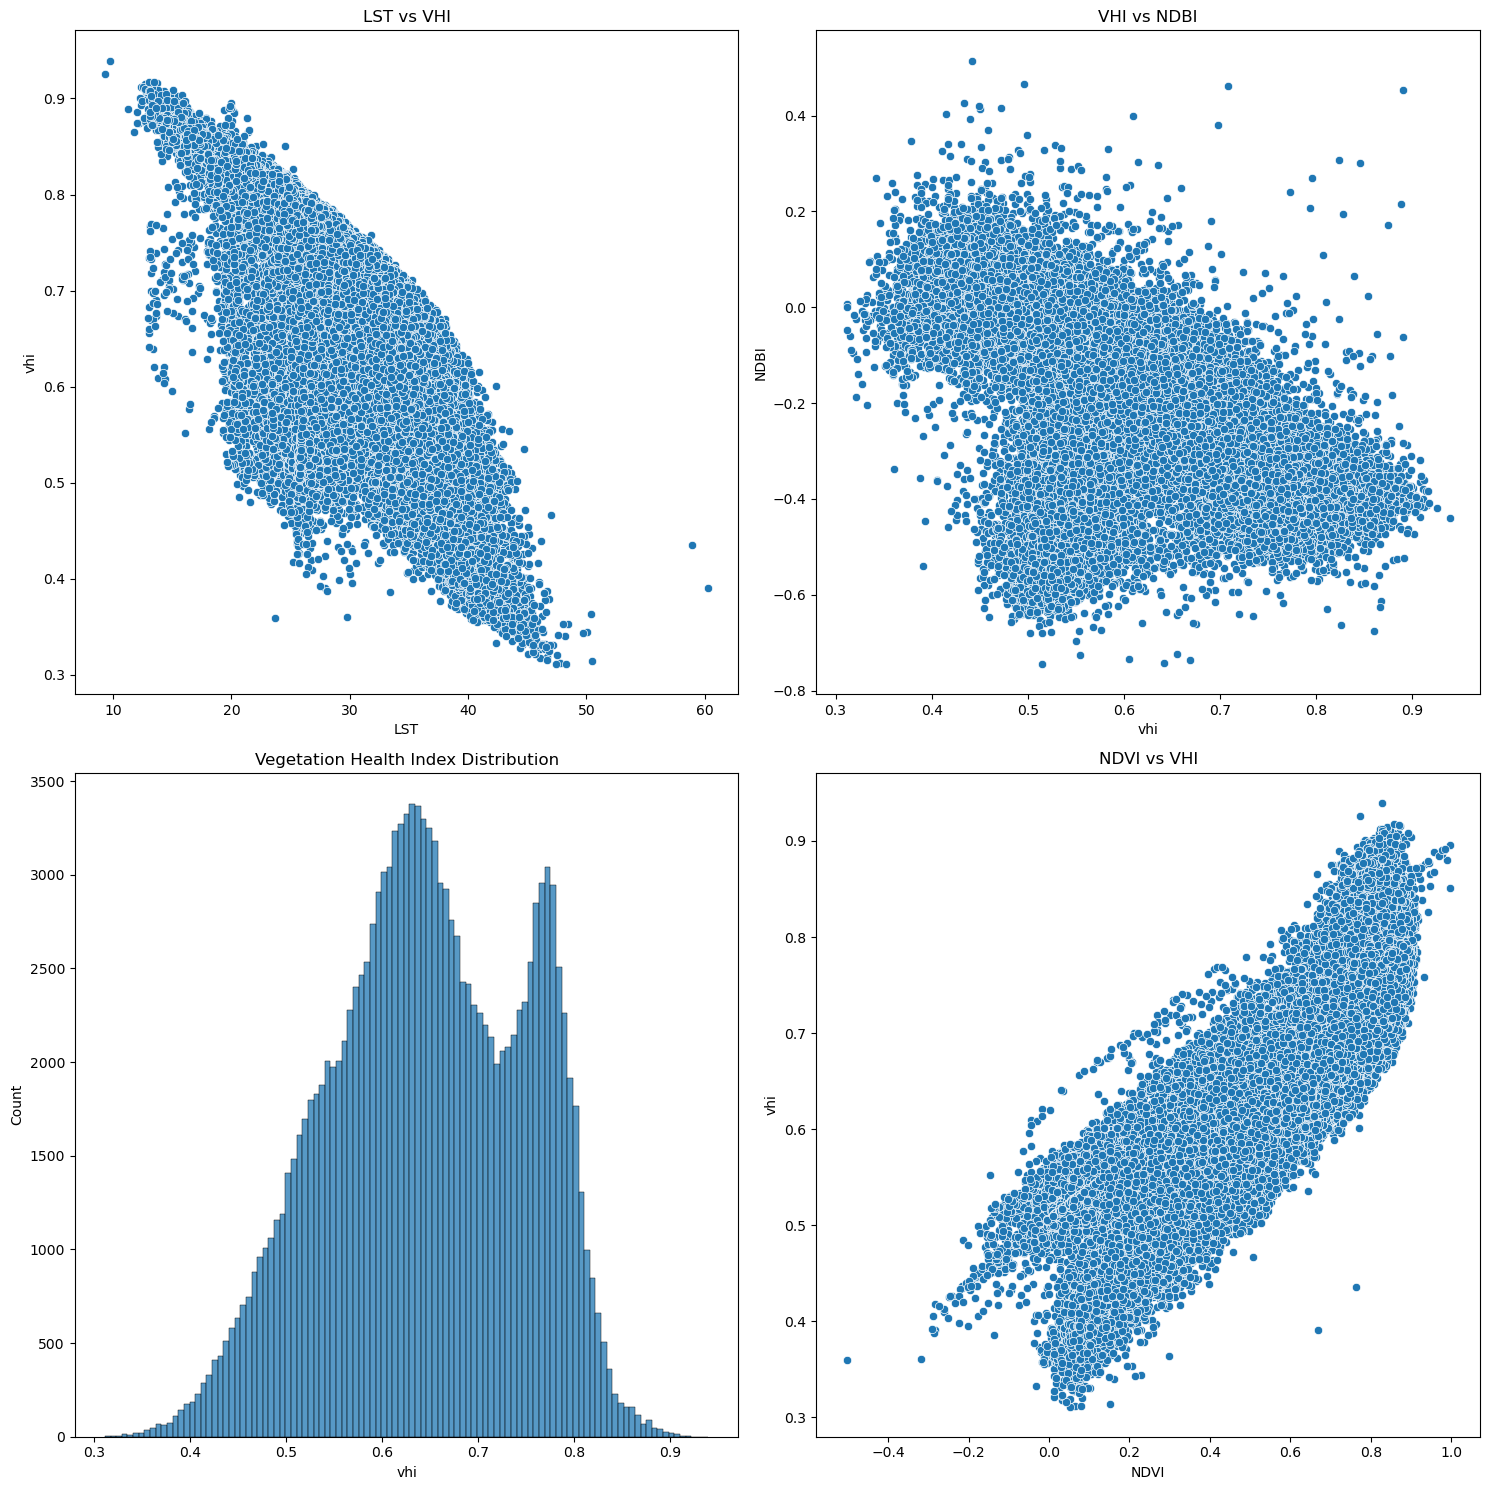

In [10]:
    
#     # Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
#     # Plot 1: LST vs NDVI
sns.scatterplot(data=combined_gdf, x='LST', y='vhi', ax=axes[0,0])
axes[0,0].set_title('LST vs VHI')
    
#     # Plot 2: LST vs NDBI
sns.scatterplot(data=combined_gdf, x='vhi', y='NDBI', ax=axes[0,1])
axes[0,1].set_title('VHI vs NDBI')
    
#     # Plot 4: VHI Distribution
sns.histplot(data=combined_gdf, x='vhi', ax=axes[1,0])
axes[1,0].set_title('Vegetation Health Index Distribution')

#     # Plot 3: NDVI vs NDBI
sns.scatterplot(data=combined_gdf, x='NDVI', y='vhi', ax=axes[1,1])
axes[1,1].set_title('NDVI vs VHI')
    
    
plt.tight_layout()
plt.savefig('output/berlin_plot', dpi=300)

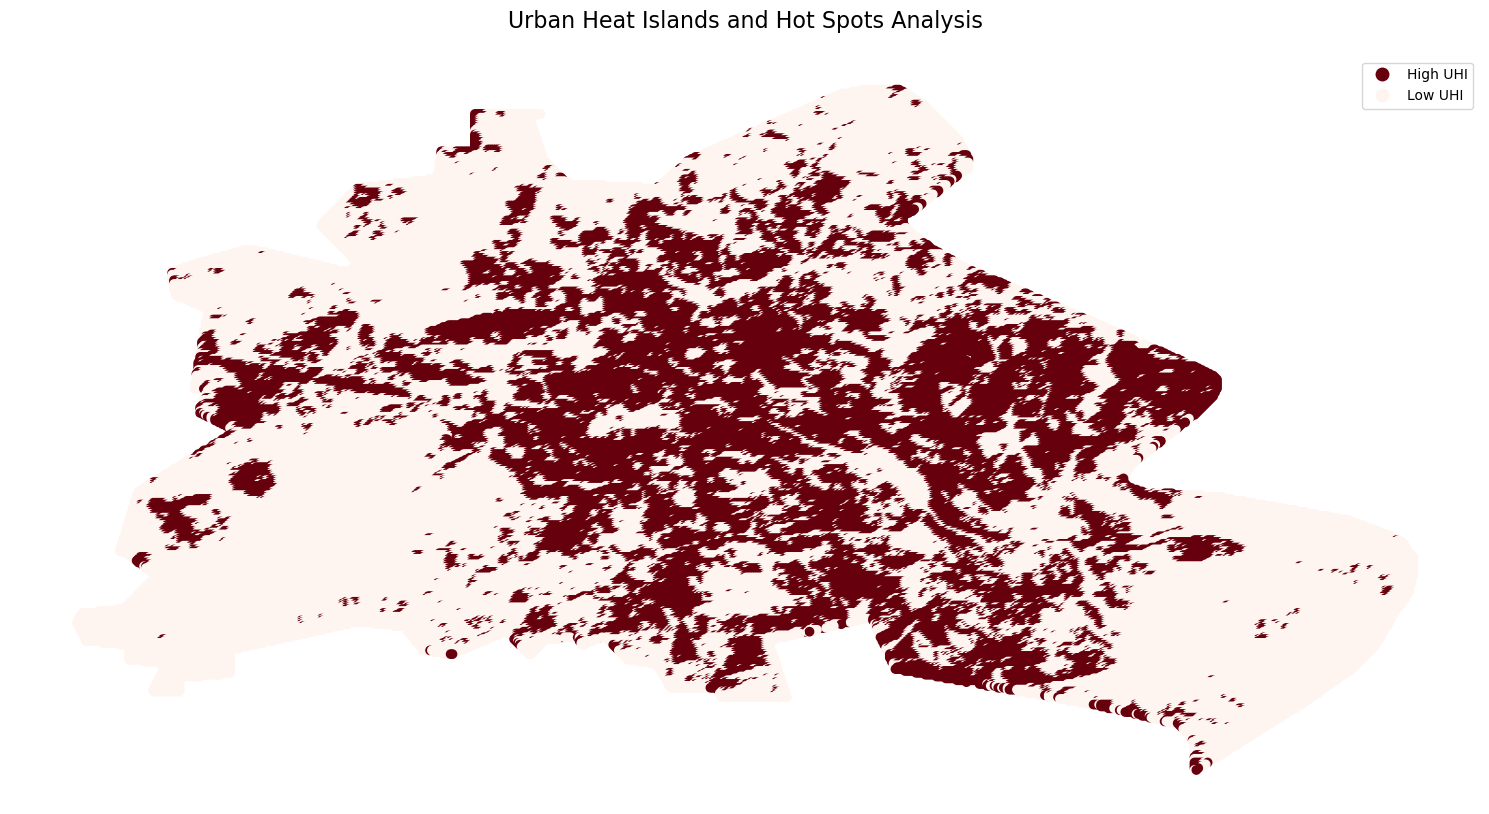

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np



fig, ax = plt.subplots(figsize=(15, 10))

combined_gdf.plot(column='uhi_class', ax=ax, legend=True, cmap='Reds_r')
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('Urban Heat Islands and Hot Spots Analysis', fontsize=16, pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('output/berlin_UHI', dpi=300)